# MODS206 - Portfolio Project


Author: Gabriele LORENZO


## Setup and Imports


In [1]:
import os
import random
import requests
import warnings

warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import bs4 as bs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import yfinance as yf

In [2]:
# risk free rate
RF = 0.02

In [3]:
resp = requests.get("http://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
soup = bs.BeautifulSoup(resp.text, "lxml")
table = soup.find("table", {"class": "wikitable sortable"})
tickers = []
start_date = "2015-01-01"
end_date = "2022-12-31"

for row in table.findAll("tr")[1:501]:
    ticker = row.findAll("td")[0].text
    tickers.append(ticker)

tickers = [
    s.replace("\n", "")
    for s in tickers
    if s.replace("\n", "")
    not in [
        "BRK.B",
        "BF.B",
        "VLTO",
        "ABNB",
        "ABNB",
        "CEG",
        "ETSY",
        "FOX",
        "FTV",
        "GEHC",
        "PYPL",
        "UBER",
        "VICI",
        "WRK",
        "KVUE",
        "DAY",
        "DOW",
        "LW",
        "HPE",
        "HWM",
        "INVH",
        "IR",
        "KHC",
        "MRNA",
    ]
]

random.seed(16)
tickerList = random.sample(tickers, 200)

In [4]:
if not os.path.isfile("./data/stocks.csv"):
    data = yf.download(tickerList, start_date, end_date)["Adj Close"]
    data.to_csv("./data/stocks.csv")

In [5]:
data = pd.read_csv("./data/stocks.csv", index_col=0)

split_date = "2020-01-01"
train = data.loc[:split_date]
test = data.loc[split_date:]

## Introduction


The aim of this project is to create a portfolio selecting some stocks of the S&P 500 index and to analyze their performance.

The project is divided into four main parts:

1. **Equally Weighted Portfolio**
2. **Market Capitalization Weighted Portfolio**
3. **Sharpe Ratio Optimization**
4. **Clustering Methods**


## Background

First of all, let's recall some basic concepts about returns and volatility of a stock.

### Returns:

The return of a stock on a given period is calculated as:

$$
    R_{t,t+1} = \frac{P_{t+1} + (D_{t,t+1}) - P_{t}}{P_{t}}
$$

where:

- $P_{t}$ is the price of the stock at time $t$
- $P_{t+1}$ is the price of the stock at time $t+1$
- $D_{t,t+1}$ is the dividend paid by the stock between time $t$ and $t+1$

Moreover, the return of a stock **over several periods** is calculated as:

$$
    R_{t,t+n} = \prod_{i=0}^{n} (1 + R_{t+i,t+i+1}) - 1
$$

This quantity is also called **cumulative return**.

If we want to calculate the cumulative return of a weighted portfolio, we can use the formula:

$$
    R_{p,t,t+n} = \sum_{i=1}^{N} w_{i} R_{i,t,t+n}
$$

where:

- $R_{p,t,t+n}$ is the cumulative return of the portfolio
- $w_{i}$ is the weight of the $i$-th stock in the portfolio
- $R_{i,t,t+n}$ is the cumulative return of the $i$-th stock in the portfolio

### Volatility:

The volatility (risk) of a stock is usually measured by the standard deviation of its returns.

We can calculate it as:

$$
    \sigma_{R} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (R_{i} - \bar{R})^{2}}
$$

where:

- $\sigma_{i}$ is the volatility of the $i$-th stock
- $R_{i}$ is the return of the $i$-th stock
- $\bar{R}$ is the average return of the stock

The volatility of a weighted portfolio can be calculated as:

$$
    \sigma_{p} = \sqrt{w^{T} \Sigma w}
$$

where:

- $\sigma_{p}$ is the volatility of the portfolio
- $w$ is the vector of weights of the stocks in the portfolio
- $\Sigma$ is the covariance matrix of the returns of the stocks in the portfolio


## First strategy: Equal weight portfolio


In this strategy we will create a portfolio with equal weights for each stock. In particular, we will consider the 200 stocks we selected previously.

The portfolio will be built as follows:

$$
    w_i = \frac{1}{N}
$$

where $w_i$ is the weight of the $i$-th stock and $N$ is the number of stocks in the portfolio (200 in our case).

$$
    \text{Portfolio}_{EW} = \sum_{i=1}^{N} w_i \cdot \text{Stock}_i
$$


In [6]:
weights = 1 / len(test.columns) * np.ones(len(test.columns))
test_daily_ret = test.pct_change().dropna()

portfolio = (test_daily_ret * weights).sum(axis=1)

The cumulative return over the period is: 46.37%


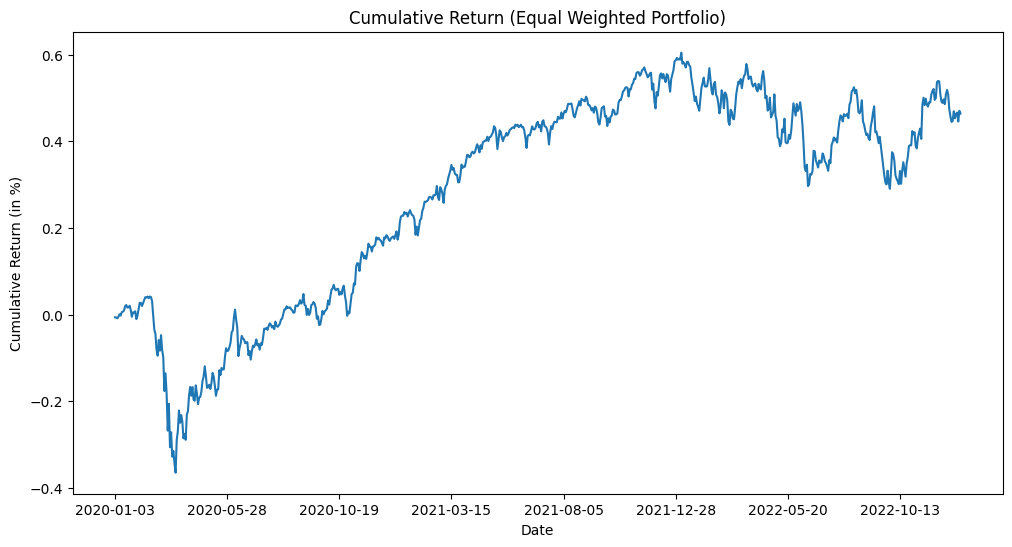

In [7]:
cumulative_ew_ret = (portfolio + 1).cumprod() - 1

cumulative_ew_ret.plot(
    figsize=(12, 6),
    title="Cumulative Return (Equal Weighted Portfolio)",
    xlabel="Date",
    ylabel="Cumulative Return (in %)",
)
print(
    f"The cumulative return over the period is: {cumulative_ew_ret.iloc[-1]*100:.2f}%"
)

## Second strategy: Market cap weighted portfolio


In this strategy we will create a portfolio with weights proportional to the market capitalization of each stock. As before, we will consider the 200 stocks we selected previously.

The portfolio will be built as follows:

$$
    w_i = \frac{MC_i}{\sum_{j=1}^{200} MC_j}
$$

where $MC_i$ is the market capitalization of the $i$-th stock.

$$
    \text{Portfolio}_{MC} = \sum_{i=1}^{N} w_i \cdot \text{Stock}_i
$$


In [8]:
if not os.path.isfile("./data/market_cap.csv"):
    market_cap = pd.DataFrame(columns=["Ticker", "Market Cap"])

    for ticker in tickerList:
        market_cap = pd.concat(
            [
                market_cap,
                pd.DataFrame(
                    {
                        "Ticker": ticker,
                        "Market Cap": yf.Ticker(ticker).info["marketCap"],
                    },
                    index=[0],
                ),
            ]
        )

    market_cap.to_csv("./data/market_cap.csv", index=False)

In [9]:
market_cap = pd.read_csv("./data/market_cap.csv", index_col=0)
weights = market_cap["Market Cap"] / market_cap["Market Cap"].sum()

test_daily_ret = test.pct_change().dropna()

portfolio = (test_daily_ret * weights).sum(axis=1)

The cumulative return over the period is: 56.38%


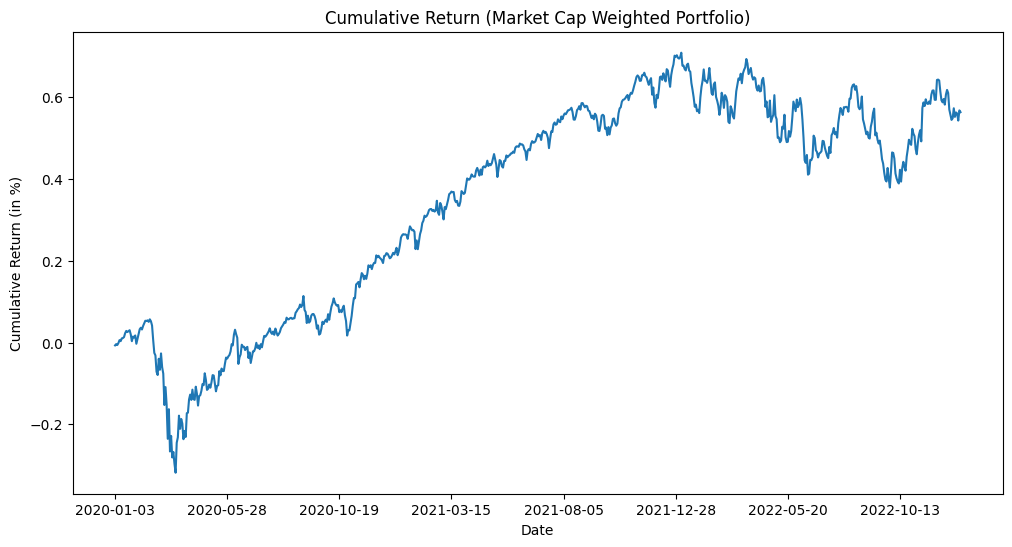

In [10]:
cumulative_mcw_ret = (portfolio + 1).cumprod() - 1

cumulative_mcw_ret.plot(
    figsize=(12, 6),
    title="Cumulative Return (Market Cap Weighted Portfolio)",
    xlabel="Date",
    ylabel="Cumulative Return (in %)",
)
print(
    f"The cumulative return over the period is: {cumulative_mcw_ret.iloc[-1]*100:.2f}%"
)

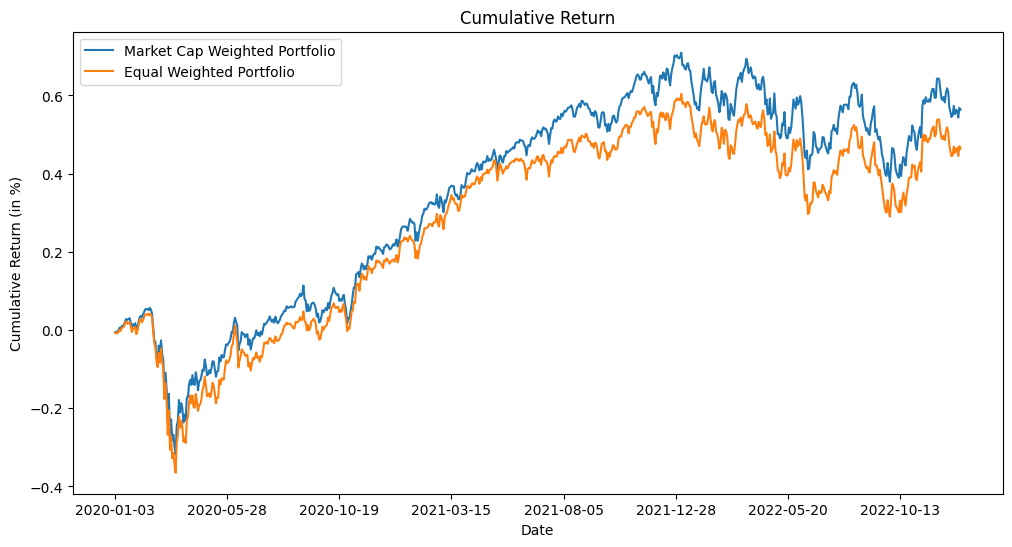

In [11]:
cumulative_mcw_ret.plot(figsize=(12, 6), label="Market Cap Weighted Portfolio")
cumulative_ew_ret.plot(label="Equal Weighted Portfolio")
plt.title("Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (in %)")
plt.legend()
plt.show()

## Third strategy: Maximize Sharpe ratio


In this strategy we will create a portfolio that maximizes the Sharpe ratio.

The Sharpe ratio is defined as:

$$
\text{Sharpe ratio} = \frac{R_p - R_f}{\sigma_p}
$$

where:

- $R_p$ is the return of the portfolio
- $R_f$ is the risk-free rate (in our case we will consider $R_f = 2\%$)
- $\sigma_p$ is the volatility of the portfolio

The portfolio will be built as follows:

$$
    \text{Portfolio}_{OPT} = \sum_{i=1}^{N} w_i \cdot \text{Stock}_i
$$

where the weights $w_i$ are chosen in order to maximize the Sharpe ratio.


In [12]:
def compute_return(weights, daily_ret):
    portfolio_daily_ret = np.dot(daily_ret, weights)
    cumulative_ret = (portfolio_daily_ret + 1).cumprod() - 1
    return cumulative_ret[-1]

In [13]:
def compute_vol(weights, daily_ret):
    portfolio_daily_ret = np.dot(daily_ret, weights)
    volatility = np.sqrt(np.dot(weights, np.dot(np.cov(portfolio_daily_ret), weights)))
    return volatility

In [14]:
def compute_sharpe_ratio(weights, daily_ret):
    ret = compute_return(weights, daily_ret)
    vol = compute_vol(weights, daily_ret)
    return -(ret - RF) / vol

In [15]:
# USE THIS CODE TO DO A K-FOLD CROSS VALIDATION TO FIND THE BEST UPPER BOUND
#
# def optimize_with_bounds(train_ret, bounds):
#     initial_weights = np.ones(len(train_ret.columns)) / len(train_ret.columns)
#
#     weights = scipy.optimize.minimize(
#         compute_sharpe_ratio,
#         initial_weights,
#         args=(train_ret),
#         constraints={"type": "eq", "fun": lambda weights: np.sum(weights) - 1},
#         bounds=[bounds for _ in range(len(train_ret.columns))],
#     )["x"]
#
#     return weights
#
# train_daily_ret = train.pct_change().dropna()
#
# # to use k-fold approach, we consider the market to follow a random walk
# n_splits = 2
# kf = KFold(n_splits=n_splits)
#
# upper_bounds = np.linspace(0.01, 0.15, 5)
# bounds_range = [(0, upper_bound) for upper_bound in upper_bounds]
#
# best_bound = None
# best_performance = float("-inf")
# average_performances = []
#
# for bound in bounds_range:
#     performances = []
#
#     for train_index, val_index in kf.split(train_daily_ret):
#         train_ret = train_daily_ret.iloc[train_index]
#         val_ret = train_daily_ret.iloc[val_index]
#
#         weights = optimize_with_bounds(train_ret, bound)
#         performance = compute_return(weights, val_ret)
#         performances.append(performance)
#
#     average_performance = np.mean(performances)
#     average_performances.append(average_performance)
#
#     if average_performance > best_performance:
#         best_performance = average_performance
#         best_bound = bound
#
# plt.plot(upper_bounds, average_performances)
# plt.title("Average Performance of Portfolio with Different Upper Bounds")
# plt.xlabel("Upper Bound")
# plt.ylabel("Average Performance")
# plt.show()
#
# print("Best Bounds:", best_bound)
# print("Best Average Performance:", best_performance)

The previous code provides a method to estimate the best bounds for the weights of the stocks in the portfolio, using a K-Fold Cross Validation approach.

However, it is quite slow and I have commented it out.

The best bound found is (0, 0.045).


In [16]:
train_daily_ret = train.pct_change().dropna()
initial_weights = np.ones(len(train_daily_ret.columns)) / len(train_daily_ret.columns)

weights = scipy.optimize.minimize(
    compute_sharpe_ratio,
    initial_weights,
    args=(train_daily_ret),
    constraints={"type": "eq", "fun": lambda weights: np.sum(weights) - 1},
    bounds=[(0, 0.045) for _ in range(len(train_daily_ret.columns))],
)["x"]

weights = np.where(weights < 0.001, 0, weights)
print("Optimal weights:\n", weights)

Optimal weights:
 [0.         0.00272019 0.0041128  0.00747909 0.0136061  0.
 0.00973601 0.00427211 0.00801342 0.         0.01579367 0.00701725
 0.00466228 0.00672873 0.03394495 0.         0.00789055 0.00443845
 0.00405182 0.         0.0116345  0.0036917  0.01137268 0.00951783
 0.01197078 0.0092023  0.00511146 0.00749798 0.         0.
 0.         0.01175693 0.00270834 0.         0.00977357 0.00162806
 0.01174693 0.01011891 0.01249882 0.01584699 0.00363123 0.00876222
 0.         0.0015522  0.01280477 0.         0.01125632 0.00768029
 0.00597907 0.         0.01909268 0.01328024 0.         0.
 0.         0.         0.03598544 0.00596964 0.         0.0104001
 0.00341643 0.00550791 0.00842102 0.00120231 0.00900012 0.00478354
 0.         0.         0.00397132 0.         0.         0.00284514
 0.00549619 0.0022141  0.01165065 0.         0.         0.
 0.00154584 0.         0.         0.00748148 0.         0.
 0.00285953 0.         0.0084621  0.0068071  0.00534225 0.00439235
 0.         0.    

In [17]:
print("Number of stocks:", len(weights[weights > 0]))
print("\nStocks in the portfolio:")

for i in range(len(weights)):
    if weights[i] > 0:
        print(f"{train_daily_ret.columns[i]}: {weights[i]*100 :.2f} %")

Number of stocks: 129

Stocks in the portfolio:
ABBV: 0.27 %
ABT: 0.41 %
ACN: 0.75 %
ADBE: 1.36 %
AEE: 0.97 %
AES: 0.43 %
AJG: 0.80 %
ALGN: 1.58 %
ALLE: 0.70 %
AMAT: 0.47 %
AMCR: 0.67 %
AMD: 3.39 %
AON: 0.79 %
APD: 0.44 %
APH: 0.41 %
ATO: 1.16 %
AVB: 0.37 %
AVGO: 1.14 %
AVY: 0.95 %
AXON: 1.20 %
BA: 0.92 %
BALL: 0.51 %
BAX: 0.75 %
BIO: 1.18 %
BKNG: 0.27 %
BRO: 0.98 %
CAT: 0.16 %
CBOE: 1.17 %
CCI: 1.01 %
CDNS: 1.25 %
CDW: 1.58 %
CFG: 0.36 %
CINF: 0.88 %
CMA: 0.16 %
CME: 1.28 %
CMS: 1.13 %
CNC: 0.77 %
COO: 0.60 %
CPRT: 1.91 %
CTAS: 1.33 %
CZR: 3.60 %
DE: 0.60 %
DG: 1.04 %
DGX: 0.34 %
DHI: 0.55 %
DTE: 0.84 %
EBAY: 0.12 %
ED: 0.90 %
EIX: 0.48 %
EQR: 0.40 %
FAST: 0.28 %
FE: 0.55 %
FITB: 0.22 %
FTNT: 1.17 %
GIS: 0.15 %
GOOG: 0.75 %
GWW: 0.29 %
HAS: 0.85 %
HCA: 0.68 %
HLT: 0.53 %
HOLX: 0.44 %
ICE: 0.85 %
IEX: 0.64 %
IFF: 0.10 %
INTU: 0.79 %
IT: 0.36 %
ITW: 0.47 %
JBL: 0.36 %
JKHY: 0.88 %
JNJ: 0.45 %
JPM: 0.75 %
K: 0.26 %
KLAC: 0.82 %
KMB: 0.32 %
KO: 0.49 %
LH: 0.15 %
LLY: 0.85 %
LNT: 0.98 %
LO

The cumulative return over the period is: 50.05%


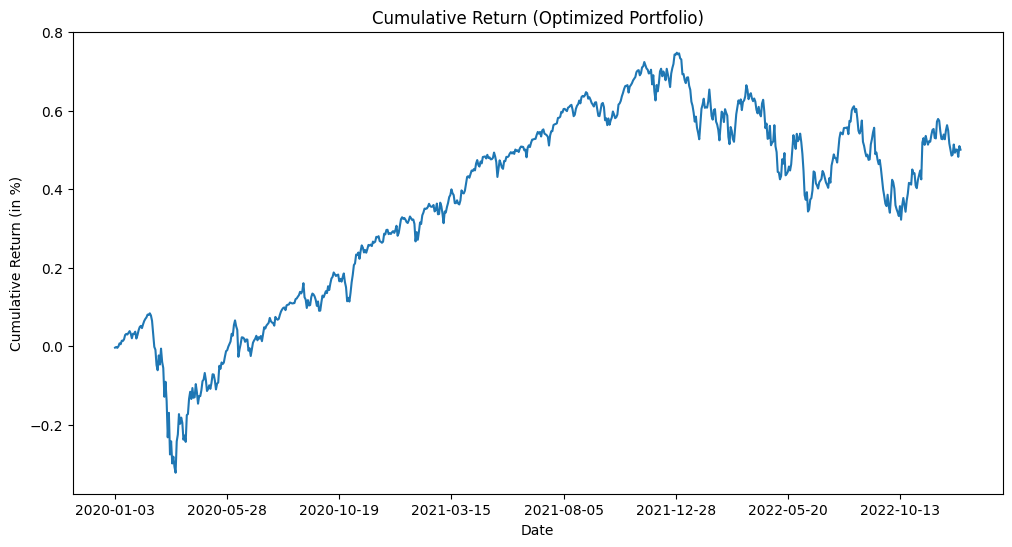

In [18]:
portfolio_daily_ret = pd.Series(np.dot(test_daily_ret, weights))
portfolio_daily_ret.index = test_daily_ret.index

cumulative_opt_ret = (portfolio_daily_ret + 1).cumprod() - 1

cumulative_opt_ret.plot(
    figsize=(12, 6),
    title="Cumulative Return (Optimized Portfolio)",
    xlabel="Date",
    ylabel="Cumulative Return (in %)",
)
print(
    f"The cumulative return over the period is: {cumulative_opt_ret.iloc[-1]*100:.2f}%"
)

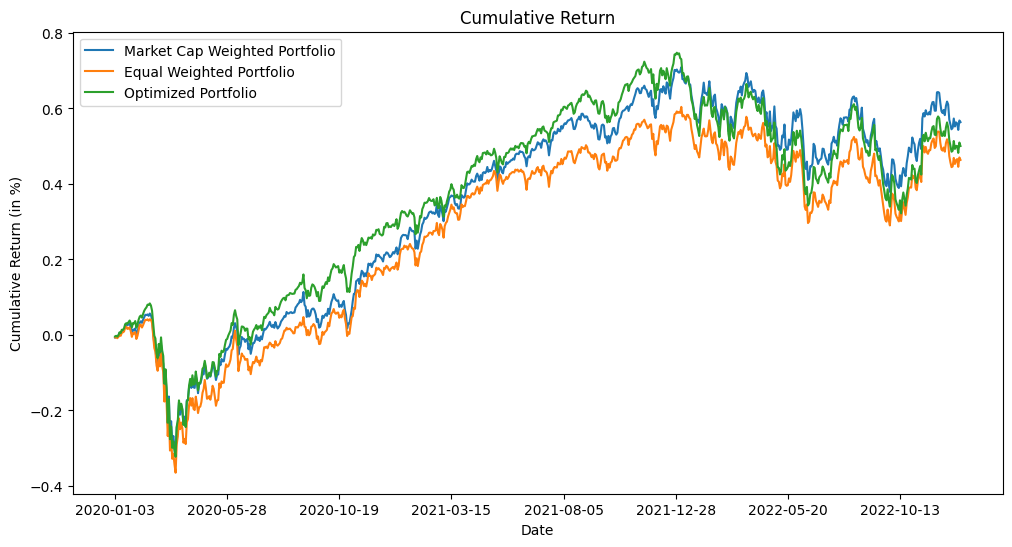

In [19]:
cumulative_mcw_ret.plot(figsize=(12, 6), label="Market Cap Weighted Portfolio")
cumulative_ew_ret.plot(label="Equal Weighted Portfolio")
cumulative_opt_ret.plot(label="Optimized Portfolio")
plt.title("Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (in %)")
plt.legend()
plt.show()

## Fourth strategy: K-means and Hirearchical clustering


### K-means clustering


In this strategy we will use the K-means clustering algorithm to group the stocks in the portfolio into $K$ clusters.

The number of clusters $K$ will be chosen using the Elbow method.

In this implementation I choose to take the 2 stocks nearest to the centroid of each cluster. If the number of stocks in the cluster is less than 2, I take the only stock present in the cluster.


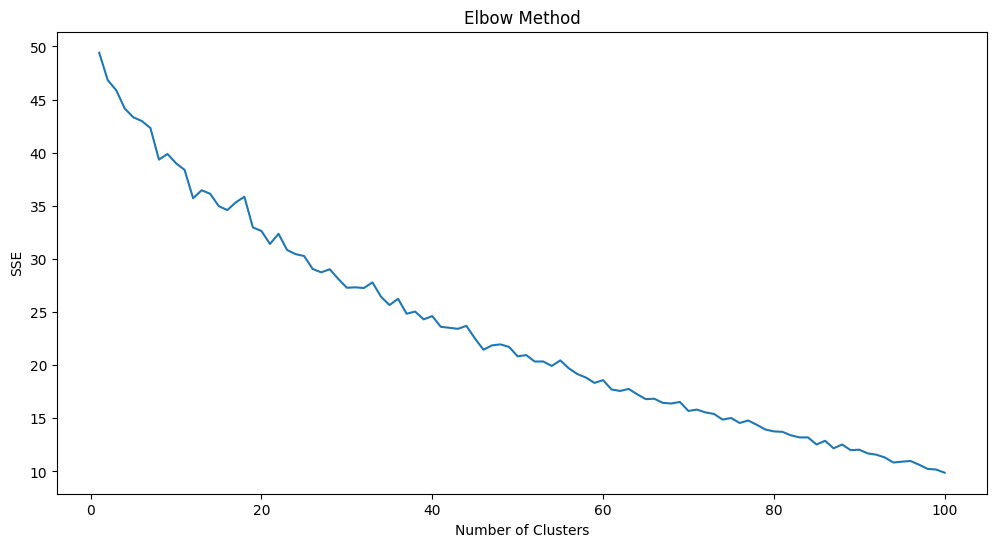

In [20]:
from sklearn.cluster import KMeans

sse = []
k_values = np.linspace(1, 100, 100, dtype=int)

train_daily_ret = train.pct_change().dropna().transpose()

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_daily_ret)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(k_values, sse)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [21]:
best_n_clusters = 25
kmeans = KMeans(n_clusters=best_n_clusters)
centroids = kmeans.fit(train_daily_ret).cluster_centers_
cluster_labels = kmeans.labels_
distance_to_centroid = kmeans.transform(train_daily_ret)

stocks = []
n_stocks_to_pick = 2

for i in range(best_n_clusters):
    cluster = train_daily_ret[cluster_labels == i]

    cluster_distance = distance_to_centroid[cluster_labels == i][:, i]
    stocks.extend(cluster.index[np.argsort(cluster_distance)[:n_stocks_to_pick]])

stocks = np.array(stocks).flatten()

print(f"We have {len(stocks)} stocks in the portfolio")
print(f"Stocks in the portfolio: {stocks}")

We have 36 stocks in the portfolio
Stocks in the portfolio: ['INTU' 'ADBE' 'JPM' 'USB' 'PCG' 'RSG' 'AJG' 'BBWI' 'L' 'TROW' 'CZR' 'COP'
 'HAL' 'AMD' 'AMAT' 'KLAC' 'BIIB' 'AAL' 'LUV' 'ITW' 'IEX' 'ULTA' 'XEL'
 'CMS' 'JKHY' 'V' 'CTRA' 'LVS' 'AXON' 'FTNT' 'MGM' 'ABBV' 'VRTX' 'GILD'
 'AVGO' 'ZBRA']


The cumulative return over the period is: 60.00%


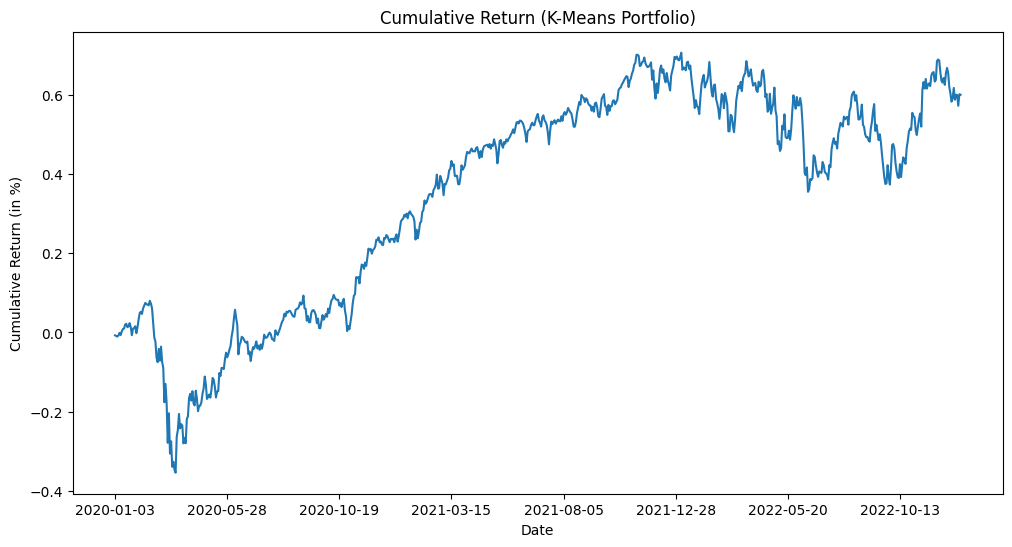

In [22]:
test_daily_ret = test.pct_change().dropna()[stocks]
weights = np.ones(len(test_daily_ret.columns)) / len(test_daily_ret.columns)

portfolio_daily_ret = (test_daily_ret * weights).sum(axis=1)
cumulative_km_ret = (portfolio_daily_ret + 1).cumprod() - 1

cumulative_km_ret.plot(
    figsize=(12, 6),
    title="Cumulative Return (K-Means Portfolio)",
    xlabel="Date",
    ylabel="Cumulative Return (in %)",
)
print(
    f"The cumulative return over the period is: {cumulative_km_ret.iloc[-1]*100:.2f}%"
)

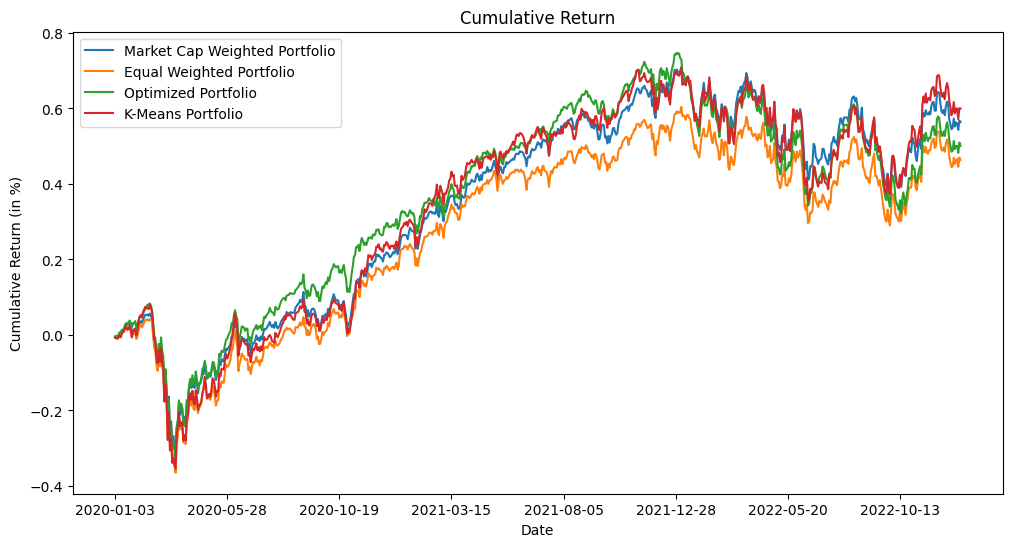

In [23]:
cumulative_mcw_ret.plot(figsize=(12, 6), label="Market Cap Weighted Portfolio")
cumulative_ew_ret.plot(label="Equal Weighted Portfolio")
cumulative_opt_ret.plot(label="Optimized Portfolio")
cumulative_km_ret.plot(label="K-Means Portfolio")
plt.title("Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (in %)")
plt.legend()
plt.show()

### Hierarchical clustering


In this strategy we will use the Hierarchical clustering algorithm to group the stocks in the portfolio into $K$ clusters.


In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

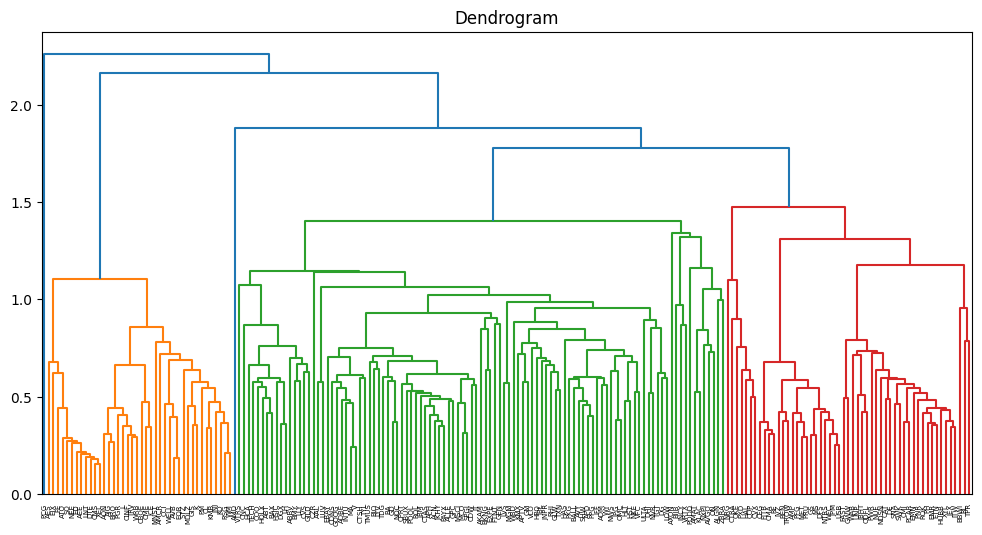

In [25]:
linkage_matrix = linkage(train_daily_ret, "ward")

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=train_daily_ret.index, leaf_rotation=90)
plt.title("Dendrogram")
plt.show()

In [26]:
n_cluster = 25
clusters = fcluster(linkage_matrix, n_cluster, criterion="maxclust")

clustered_stocks = {}

for i in range(1, n_cluster + 1):
    clustered_stocks[i] = train_daily_ret.index[clusters == i]

print(clustered_stocks)

{1: Index(['AEE', 'AES', 'ATO', 'CMS', 'DTE', 'ED', 'EIX', 'FE', 'LNT', 'NEE',
       'SO', 'XEL'],
      dtype='object'), 2: Index(['AJG', 'AMCR', 'AON', 'AVB', 'BRO', 'CBOE', 'CCI', 'CINF', 'CL', 'CME',
       'EQR', 'GIS', 'ICE', 'JNJ', 'K', 'KMB', 'KO', 'L', 'MDLZ', 'MNST',
       'PGR', 'PM', 'RSG', 'STZ', 'TRV', 'WELL', 'WM', 'WRB'],
      dtype='object'), 3: Index(['ABBV', 'ABT', 'BAX', 'BMY', 'CNC', 'COO', 'CVS', 'DGX', 'GILD', 'HCA',
       'HOLX', 'HSIC', 'LH', 'LLY', 'TECH'],
      dtype='object'), 4: Index(['VTRS'], dtype='object'), 5: Index(['AAL', 'LUV'], dtype='object'), 6: Index(['ACN', 'ADBE', 'AKAM', 'ALLE', 'APH', 'BA', 'BIO', 'BKNG', 'CDNS',
       'CDW', 'CPRT', 'CTAS', 'CTSH', 'EBAY', 'EXPE', 'FTNT', 'GD', 'GEN',
       'GOOG', 'GPC', 'IBM', 'INTU', 'IT', 'JKHY', 'LYV', 'MA', 'MCO', 'MSCI',
       'NOC', 'PAYX', 'POOL', 'ROL', 'SBUX', 'SPGI', 'TDG', 'TMUS', 'TYL',
       'V'],
      dtype='object'), 7: Index(['LVS', 'MGM'], dtype='object'), 8: Index(['ADM', 'APD',

In [27]:
stocks = []
n_stocks_to_pick = 2

for i in range(1, n_cluster + 1):
    cluster = clustered_stocks[i]

    for j in range(n_stocks_to_pick):
        if j < len(cluster):
            stocks.append(random.choice(cluster))

stocks = np.sort(np.array(stocks))

print(f"We have {len(stocks)} stocks in the portfolio")
print(f"Stocks in the portfolio: {stocks}")

We have 39 stocks in the portfolio
Stocks in the portfolio: ['AAL' 'ALGN' 'AMAT' 'AMD' 'AON' 'AXON' 'BA' 'BBWI' 'BIIB' 'COP' 'CZR'
 'DHI' 'FE' 'HOLX' 'HOLX' 'HST' 'IVZ' 'LNT' 'LUV' 'LVS' 'MGM' 'MS' 'NDSN'
 'NKE' 'NRG' 'NXPI' 'PAYX' 'PCG' 'PODD' 'PXD' 'RL' 'RL' 'ROK' 'TGT' 'TRV'
 'VRTX' 'VRTX' 'VTRS' 'ZBRA']


The cumulative return over the period is: 45.39%


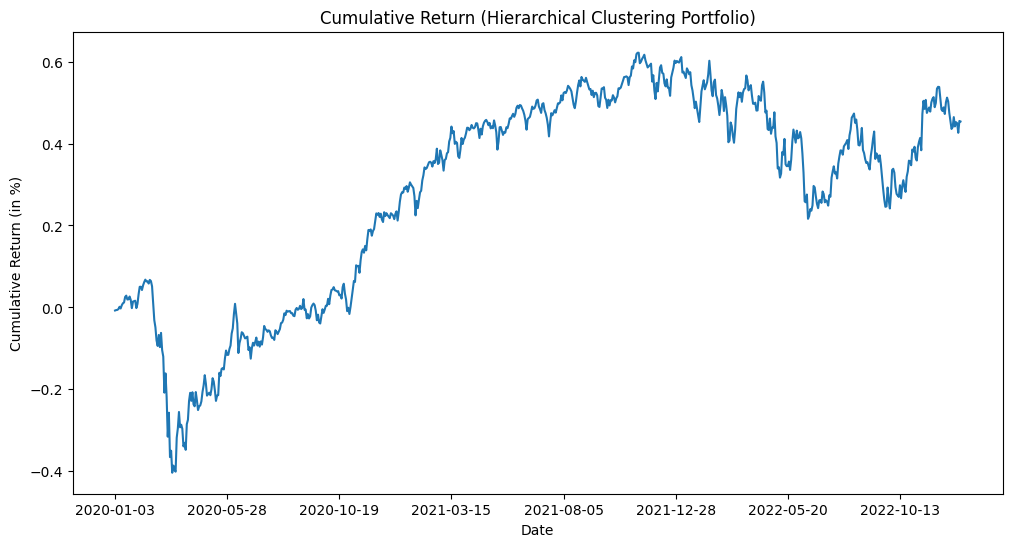

In [28]:
test_daily_ret = test.pct_change().dropna()[stocks]
weights = np.ones(len(test_daily_ret.columns)) / len(test_daily_ret.columns)

portfolio_daily_ret = (test_daily_ret * weights).sum(axis=1)
cumulative_hk_ret = (portfolio_daily_ret + 1).cumprod() - 1

cumulative_hk_ret.plot(
    figsize=(12, 6),
    title="Cumulative Return (Hierarchical Clustering Portfolio)",
    xlabel="Date",
    ylabel="Cumulative Return (in %)",
)
print(
    f"The cumulative return over the period is: {cumulative_hk_ret.iloc[-1]*100:.2f}%"
)

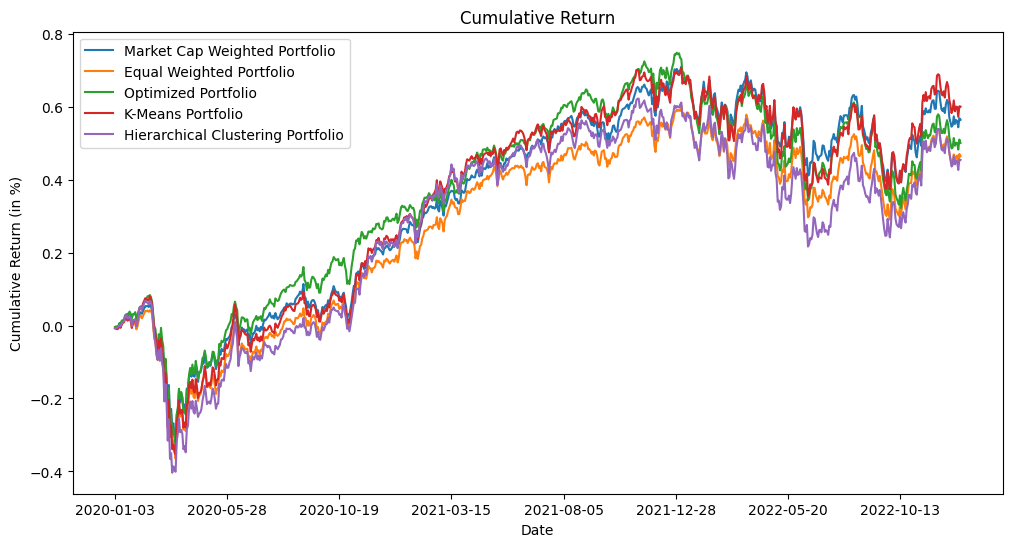

In [29]:
cumulative_mcw_ret.plot(figsize=(12, 6), label="Market Cap Weighted Portfolio")
cumulative_ew_ret.plot(label="Equal Weighted Portfolio")
cumulative_opt_ret.plot(label="Optimized Portfolio")
cumulative_km_ret.plot(label="K-Means Portfolio")
cumulative_hk_ret.plot(label="Hierarchical Clustering Portfolio")

plt.title("Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (in %)")
plt.legend()
plt.show()

## Conclusion


In [30]:
cumulative_returns = [
    cumulative_ew_ret.iloc[-1] * 100,
    cumulative_mcw_ret.iloc[-1] * 100,
    cumulative_opt_ret.iloc[-1] * 100,
    cumulative_km_ret.iloc[-1] * 100,
    cumulative_hk_ret.iloc[-1] * 100,
]

strategies = [
    "Equally Weighted",
    "Market Cap Weighted",
    "Sharpe Ratio",
    "KMeans",
    "Hierarchical Clustering",
]

results = pd.DataFrame(
    {"Strategy": strategies, "Cumulative Return [%]": cumulative_returns}
)

# sort the results by cumulative return
display(results.sort_values("Cumulative Return [%]", ascending=False, inplace=False))

,Strategy,Cumulative Return [%]
3,KMeans,60.003058
1,Market Cap weighted,56.380304
2,Sharp Ratio,50.053517
0,Equally Weighted,46.371698
4,Hierarchical Clustering,45.390050


We can see that the best performing strategy is the Market Cap Weighted Portfolio.

Sometime the Clustering methods can give good results, but they are not always reliable as they have a random component.
